In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob as glob

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
from fig_utils import *

In [4]:
calp_path = "../DATASORT/CALP/DATA/"

## top panel (a)

#### reading data and calculations

In [5]:
## read in data: correlations between CA precip and Nino3.4 and historical trends
ca_cor5 = xr.open_dataset(calp_path+"CMIP5calpvalues.nc")
ca_cor6 = xr.open_dataset(calp_path+"CMIP6calpvalues.nc")

In [6]:
ca_cor5

<xarray.Dataset>
Dimensions:          (Model: 37)
Coordinates:
  * Model            (Model) object 'ACCESS1-0' 'ACCESS1-3' ... 'NorESM1-ME'
Data variables:
    prtrend_cal      (Model) float64 ...
    cor_nino_calp_p  (Model) float64 ...
    cor_nino_calp_f  (Model) float64 ...

In [7]:
## order models by low to high correlation over future period
order5 = np.argsort(ca_cor5["cor_nino_calp_f"].values)
model_order5 = ca_cor5["Model"][order5]
order6 = np.argsort(ca_cor6["cor_nino_calp_f"].values)
model_order6 = ca_cor6["Model"][order6]

In [8]:
## read in data: observed CA precip and Nino3.4 time series
obs_ds = xr.open_dataset(calp_path+"obsdata.nc")

In [9]:
## calculate Nino3.4 and CA precip correlation in observations
obs_cor = pd.DataFrame()

p_obs_labels = ["CRU", "GPCC"]
p_obs_vars = ["prcal_cruts", "prcal_gpcc"]
nino_obs_labels = ["Had", "v3b", "v5"]
nino_obs_vars = ["nino34_hadisst", "nino34_ersstv3b", "nino34_ersstv5"]

for i, p in enumerate(p_obs_labels):
    for j, nino in enumerate(nino_obs_labels):
        df = pd.DataFrame({"p_obs":p, "nino_obs": nino, "label":"r("+p+","+nino+")", 
                           "cor": [np.corrcoef(obs_ds[p_obs_vars[i]].values, obs_ds[nino_obs_vars[j]].values)[0,1]]})
        obs_cor = obs_cor.append(df)


In [10]:
obs_cor

,p_obs,nino_obs,label,cor
0,CRU,Had,"r(CRU,Had)",0.344689
0,CRU,v3b,"r(CRU,v3b)",0.352084
0,CRU,v5,"r(CRU,v5)",0.338715
0,GPCC,Had,"r(GPCC,Had)",0.311442
0,GPCC,v3b,"r(GPCC,v3b)",0.317702
0,GPCC,v5,"r(GPCC,v5)",0.305555


In [11]:
## read processed Large Ensemble data into one DataArray
le_files = sorted(glob.glob(calp_path+"/cor_nino34*.nc"))
ca_cor_le = []
le_order = ["CanESM2", "CESM1-CAM5", "CSIRO-Mk3-6-0", "GFDL-CM3", "MPI-ESM"]

for file in le_files:
    #parse model name
    MODEL = file.split("_")[3].split(".")[0]
    ds = xr.open_dataset(file)
    n = len(ds["cor_nino34_calp"])
    ds = ds.expand_dims({"Model": np.repeat(MODEL, n)})
    ca_cor_le.append(ds)
    
ca_cor_le = xr.concat(ca_cor_le, dim = "Model") ## LEs that have <100 members will have some nans that don't affect min/max calcs

#### set up figure 

In [12]:
x5 = np.arange(1,38) # x-axis values for CMIP5 models
x6 = np.arange(39, 77) # x-axis values for CMIP6 models
xle = np.arange(82, 87) # x-axis values for large ensembles
xlabels = np.concatenate([model_order5, model_order6, le_order])

In [13]:
from matplotlib.lines import Line2D

In [14]:
cmip_col_past = [[252/255, 190/255, 166/255, 1], [200/255, 221/255, 240/255, 1]]
obs_linestyles = ['solid', "dotted", "dashed", "dashdot", (0, (3, 3, 1, 3, 1, 3, 1, 3)), (0, (8, 5))]
obs_legend_lines = [Line2D([0], [0], color = "k", linestyle = obs_linestyles[0]),
                   Line2D([0], [0], color = "k", linestyle = obs_linestyles[1]),
                   Line2D([0], [0], color = "k", linestyle = obs_linestyles[2]),
                   Line2D([0], [0], color = "k", linestyle = obs_linestyles[3]),
                   Line2D([0], [0], color = "k", linestyle = obs_linestyles[4]), 
                   Line2D([0], [0], color = "k", linestyle = obs_linestyles[5])]

In [15]:
al2017_h_models = ['CMCC-CM', 'IPSL-CM5A-MR', 'CESM1-BGC',
       'bcc-csm1-1-m', 'IPSL-CM5A-LR', 'CMCC-CMS', 'MRI-CGCM3', 'IPSL-CM5B-LR',
       'CCSM4', 'BNU-ESM', 'CanESM2', 'MIROC5', 'CESM1-CAM5','GFDL-CM3']
al2017_l_models = ['MIROC-ESM', 'GISS-E2-R', 'MIROC-ESM-CHEM', 'GISS-E2-H', 'EC-EARTH',
       'bcc-csm1-1', 'GFDL-ESM2G', 'HadGEM2-AO','HadGEM2-CC', 'GFDL-ESM2M']

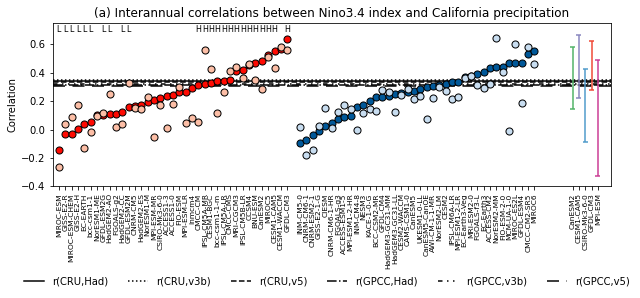

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

ax.set(title = "(a) Interannual correlations between Nino3.4 index and California precipitation", 
       ylim = (-0.4, 0.75), ylabel = "Correlation", xlim = (0, 88))
ax.set_xticks(ticks = np.concatenate([x5, x6, xle]))
ax.set_xticklabels(labels = xlabels, rotation=90, ## still troubleshooting issues with alignment for angled text 
                   ha = "center", size = 7.5)

## plot cmip correlations
ax.scatter(x5, ca_cor5["cor_nino_calp_f"][order5], color = cmip_col[0], edgecolor = "k", zorder = 10, s = 50)
ax.scatter(x6, ca_cor6["cor_nino_calp_f"][order6], color = cmip_col[1], edgecolor = "k", zorder = 10, s = 50)
ax.scatter(x5, ca_cor5["cor_nino_calp_p"][order5], color = cmip_col_past[0], edgecolor = "k", zorder = 20, s = 50)
ax.scatter(x6, ca_cor6["cor_nino_calp_p"][order6], color = cmip_col_past[1], edgecolor = "k", zorder = 20, s = 50)
## !! ADD LEGENDS !!

for model in al2017_h_models:
    ax.text(x5[model_order5 == model], 0.69, "H", size = 8, ha = "center")
for model in al2017_l_models:
    ax.text(x5[model_order5 == model], 0.69, "L", size = 8, ha = "center")
    
## !!! TO DO: ADD GRAY SHADING FOR 95% CI

## add LE correlation ranges
for i, le in enumerate(le_order):
    ymin = ca_cor_le.sel(Model = le)["cor_nino34_calp"].min().values
    ymax = ca_cor_le.sel(Model = le)["cor_nino34_calp"].max().values
    ax.errorbar(xle[i], (ymin+ymax)/2, yerr = (ymax-ymin)/2, color = le_col[i], fmt = 'none')
    ax.hlines([ymin, ymax], xle[i]-0.4, xle[i]+0.4, color = le_col[i])

ax.hlines(obs_cor["cor"], 0, 88, linestyles = obs_linestyles, color = "k", zorder = 0) ## ADD LEGEND
ax.legend(obs_legend_lines, obs_cor["label"], bbox_to_anchor = (1.05, -.5), ncol = 6, frameon = False)

fig.savefig("./figure13_top.pdf", bbox_inches = "tight")

## middle panel (b-e)

#### reading data and calculations

In [17]:
## Group models by high/low correlation: r(Nino3.4, CA precip)

high_thr = 0.3 # threshold for high correlation
low_thr = 0.2 # threshold for low correlation

highr_models_fut5 = ca_cor5["Model"].values[ca_cor5["cor_nino_calp_f"].values > high_thr]
lowr_models_fut5 = ca_cor5["Model"].values[ca_cor5["cor_nino_calp_f"].values < low_thr]
highr_models_past5 = ca_cor5["Model"].values[ca_cor5["cor_nino_calp_p"].values > high_thr]
lowr_models_past5 = ca_cor5["Model"].values[ca_cor5["cor_nino_calp_p"].values < low_thr]

highr_models_fut6 = ca_cor6["Model"].values[ca_cor6["cor_nino_calp_f"].values > high_thr]
lowr_models_fut6 = ca_cor6["Model"].values[ca_cor6["cor_nino_calp_f"].values < low_thr]
highr_models_past6 = ca_cor6["Model"].values[ca_cor6["cor_nino_calp_p"].values > high_thr]
lowr_models_past6 = ca_cor6["Model"].values[ca_cor6["cor_nino_calp_p"].values < low_thr]


In [18]:
## read in data: future precip trends (gridded)
lats = np.arange(10, 80)
lons = np.arange(190, 310)

ptrend5 = xr.open_dataset(calp_path+"CMIP5calpmaptrends.nc").sel(lat = lats, lon = lons)
ptrend6 = xr.open_dataset(calp_path+"CMIP6calpmaptrends.nc").sel(lat = lats, lon = lons)

#### set up figure

In [19]:
ptrend_col = combine_cmaps(n = 18, white = 4, neg = "YlOrBr", pos = "GnBu", start = 0.2)
ptrend_breaks = np.arange(-1, 1.05, 0.05)

In [20]:
def format_map(ax):
    ax.set_aspect('auto')
    ax.set_extent([-170, -50, 10, 80], crs = ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)

    ax.set_xticks([-160, -130, -100, -70], crs=ccrs.PlateCarree())
    ax.set_yticks([20, 40, 60, 80], crs=ccrs.PlateCarree())
    
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, 
                                                   degree_symbol=''))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

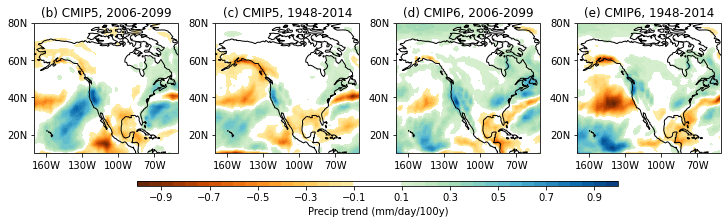

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), 
                         constrained_layout = True, 
                         subplot_kw={'projection': ccrs.PlateCarree()})

## b
ax = axes[0]
cf = ax.contourf(lons - 360, lats, # for some reason converting lons to -180-180 instead of 0-360 was necessary to plot correctly
            (ptrend5.sel(Model = highr_models_fut5).mean(dim = "Model") - 
              ptrend5.sel(Model = lowr_models_fut5).mean(dim = "Model"))["prtrend_2006_2099"], 
            cmap = ptrend_col, levels = ptrend_breaks, transform = ccrs.PlateCarree())
ax.set_title("(b) CMIP5, 2006-2099")
format_map(ax)


## c
ax = axes[1]
ax.set_title("(c) CMIP5, 1948-2014")
cf = ax.contourf(lons - 360, lats,
            (ptrend5.sel(Model = highr_models_past5).mean(dim = "Model") - 
              ptrend5.sel(Model = lowr_models_past5).mean(dim = "Model"))["prtrend_2006_2099"], 
            cmap = ptrend_col, levels = ptrend_breaks, transform = ccrs.PlateCarree())
format_map(ax)

## d
ax = axes[2]
ax.set_title("(d) CMIP6, 2006-2099")
cf = ax.contourf(lons - 360, lats, 
            (ptrend6.sel(Model = highr_models_fut6).mean(dim = "Model") - 
              ptrend6.sel(Model = lowr_models_fut6).mean(dim = "Model"))["prtrend_2006_2099"], 
            cmap = ptrend_col, levels = ptrend_breaks, transform = ccrs.PlateCarree())
format_map(ax)

## e
ax = axes[3] 
ax.set_title("(e) CMIP6, 1948-2014")
cf = ax.contourf(lons - 360, lats, 
            (ptrend6.sel(Model = highr_models_past6).mean(dim = "Model") - 
              ptrend6.sel(Model = lowr_models_past6).mean(dim = "Model"))["prtrend_2006_2099"], 
            cmap = ptrend_col, levels = ptrend_breaks, transform = ccrs.PlateCarree())
format_map(ax)

fig.colorbar(cf, ax = axes, location = "bottom", shrink = 0.7, label = "Precip trend (mm/day/100y)", 
            ticks = np.arange(-0.9, 1.1, 0.2));

fig.savefig("./figure13_middle.pdf", bbox_inches = "tight")

## bottom panel (f-i)

#### regression calculations

In [22]:
cmip_ds = [ca_cor5, ca_cor6]
cmip_names = ["CMIP5", "CMIP6"]
time_periods = ["2006-2099", "1948-2014"]
cor_vars = ["cor_nino_calp_f", "cor_nino_calp_p"]

In [23]:
from scipy import odr ## Orthogonal Distance Regression

In [24]:
## set up linear model for use with ODR
def lin_fun(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

lin = odr.Model(lin_fun)

In [25]:
## calculate regressions
calp_regs = pd.DataFrame()

for i, cmip in enumerate(cmip_names):
    for j, period in enumerate(time_periods):
        df = pd.DataFrame({"cmip":[cmip], "time_period": [period]}) 
        
        ## !!testing OLS without weights!!
        dat = odr.Data(cmip_ds[i][cor_vars[j]].values, cmip_ds[i]["prtrend_cal"].values, wd=0) 
        n = len(cmip_ds[i]["Model"])
        odreg = odr.ODR(dat, lin, beta0=[1., 0.2], ##initial coefficients for slope and intercept based on OLS results
                        ifixx = np.zeros(n)) ## fix x obs for OLS
        df[["ols_slope", "ols_int"]] = odreg.run().beta
        
        ## !!testing TLS without weights!!
        dat = odr.Data(cmip_ds[i][cor_vars[j]].values, cmip_ds[i]["prtrend_cal"].values, wd=0) 
        odreg = odr.ODR(dat, lin, beta0=[1., 0.2]) ##initial coefficients for slope and intercept based on OLS results
        df[["tls_slope", "tls_int"]] = odreg.run().beta
        
        calp_regs = calp_regs.append(df)

#### figure

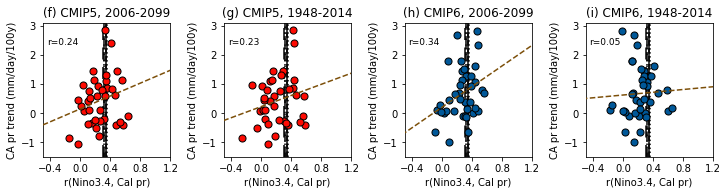

In [26]:
letters = ["(f) ", "(g) ", "(h) ", "(i) "]
ymin = -1.5
ymax = 3.1

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 2.6), 
                         constrained_layout = True)

for i, cmip in enumerate(cmip_names):
    for j, period in enumerate(time_periods):
        k = i*2+j
        ax = axes[k]
        ax.set(title = letters[k]+cmip+", "+period, ylabel = "CA pr trend (mm/day/100y)", xlabel = "r(Nino3.4, Cal pr)", 
        xlim = (-0.5, 1), ylim = (ymin, ymax), xticks = np.arange(-.4, 1.4, .4), yticks = np.arange(-1, 4))
        ax.vlines(obs_cor["cor"], ymin, ymax, linestyles = obs_linestyles, color = "k", zorder = 0)
        ax.scatter(cmip_ds[i][cor_vars[j]], cmip_ds[i]["prtrend_cal"], color = cmip_col[i], edgecolor = "k", s = 50, zorder = 10)
       
        ## !!! plotting OLS as an example !! need to add error weighting !!
        ax.plot(np.arange(ymin, ymax+0.5, 0.5), 
                np.arange(ymin, ymax+0.5, 0.5)*calp_regs.iloc[k]["ols_slope"] + calp_regs.iloc[k]["ols_int"], 
                zorder = 20, linewidth = 1.5, linestyle = "dashed", color = ols_col)
        ax.text(0.03, 0.84, "r="+str(np.round(np.corrcoef(cmip_ds[i][cor_vars[j]].values, cmip_ds[i]["prtrend_cal"].values)[0,1], 2)), 
               transform = ax.transAxes, size = 9)
        
fig.savefig("./figure13_bottom.pdf", bbox_inches = "tight")